# 波士顿房价预测-作业1

本次作业运用神经网络构建一个简单的回归预测模型，对波士顿房价进行预测。报告内容包括数据预处理、特征降维、模型构建、训练、评估以及模型保存。

In [1]:
# 导入所需的库
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import logging
import matplotlib.pyplot as plt

## 一、数据的加载和预处理

首先从xlsx文件中导入数据，然后进行预处理：删除缺失值与重复值，然后将前12列作为特征、`MEDV`作为目标变量。
并对数据进行划分、标准化及 PCA 降维。

In [2]:
# 设置日志记录
logging.basicConfig(level=logging.INFO,force=True,
                            format='%(asctime)s - %(levelname)s - %(message)s',
                            handlers=[
                                logging.FileHandler("training.log"),
                                logging.StreamHandler()
                            ])
# 1.导入数据
data=pd.read_excel("BostonHousingData.xlsx")
# 2.数据预处理
data=data.dropna() # 删除缺失值
data=data.drop_duplicates() # 删除重复值
# 前12列作为特征，MEDV作为目标变量
X=data.iloc[:,:12].values
y=data['MEDV'].values
# 3.数据划分：前450条训练，后50条测试
X_train=X[:450]
y_train=y[:450]
X_test=X[-50:]
y_test=y[-50:]
# 4.数据标准化和PCA降维
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
pca=PCA(n_components=0.9) # 保留90%的方差
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
logging.info(f"原始特征数: {X.shape[1]}")
logging.info(f"经过PCA降维后的特征数: {X_train.shape[1]}")

2025-04-07 17:16:04,629 - INFO - 原始特征数: 12
2025-04-07 17:16:04,629 - INFO - 经过PCA降维后的特征数: 7


## 二、数据转换与数据加载器

将pandas导入的数据转换为PyTorch的tensor，并创建数据加载器以便于模型训练。

In [3]:
# 5.数据转换为numpy数组
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)
# 数据转换为PyTorch的tensor，并调整目标维度为二维张量
X_train_tensor=torch.tensor(X_train, dtype=torch.float32)
y_train_tensor=torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor=torch.tensor(X_test, dtype=torch.float32)
y_test_tensor=torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
# 6.创建训练数据集与数据加载器
train_dataset=TensorDataset(X_train_tensor, y_train_tensor)
train_loader=DataLoader(train_dataset, batch_size=32, shuffle=True)

## 三、构建神经网络模型

构建一个简单的回归神经网络模型，包含两个隐藏层，使用ReLU激活函数。

In [4]:
# 7.定义神经网络模型
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.model(x)
input_dim = X_train_tensor.shape[1]
model = RegressionNN(input_dim)
# 8.定义损失函数与优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 四、模型训练过程

训练模型150个周期，并在每10个周期输出一次当前的损失值。训练完成后，最终模型被保存在 `boston_model.pth` 文件中，可用于后续预测任务。

In [5]:
# 9.训练模型
num_epochs = 280
train_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    if (epoch+1) % 10 == 0:
        logging.info(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
# 保存模型
torch.save(model.state_dict(), 'boston_model.pth')
logging.info("模型已保存为 boston_model.pth")

2025-04-07 17:16:05,214 - INFO - Epoch [10/280], Loss: 88.9619
2025-04-07 17:16:05,275 - INFO - Epoch [20/280], Loss: 35.9682
2025-04-07 17:16:05,345 - INFO - Epoch [30/280], Loss: 28.8423
2025-04-07 17:16:05,410 - INFO - Epoch [40/280], Loss: 29.5891
2025-04-07 17:16:05,470 - INFO - Epoch [50/280], Loss: 2.6788
2025-04-07 17:16:05,531 - INFO - Epoch [60/280], Loss: 3.3879
2025-04-07 17:16:05,591 - INFO - Epoch [70/280], Loss: 17.6255
2025-04-07 17:16:05,651 - INFO - Epoch [80/280], Loss: 12.7631
2025-04-07 17:16:05,711 - INFO - Epoch [90/280], Loss: 0.2420
2025-04-07 17:16:05,772 - INFO - Epoch [100/280], Loss: 7.4494
2025-04-07 17:16:05,832 - INFO - Epoch [110/280], Loss: 48.1399
2025-04-07 17:16:05,892 - INFO - Epoch [120/280], Loss: 12.5070
2025-04-07 17:16:05,953 - INFO - Epoch [130/280], Loss: 27.0585
2025-04-07 17:16:06,013 - INFO - Epoch [140/280], Loss: 4.2176
2025-04-07 17:16:06,074 - INFO - Epoch [150/280], Loss: 26.0100
2025-04-07 17:16:06,134 - INFO - Epoch [160/280], Loss

## 五、模型评估

加载保存的模型，并在测试集上评估模型表现，输出测试集的损失值。

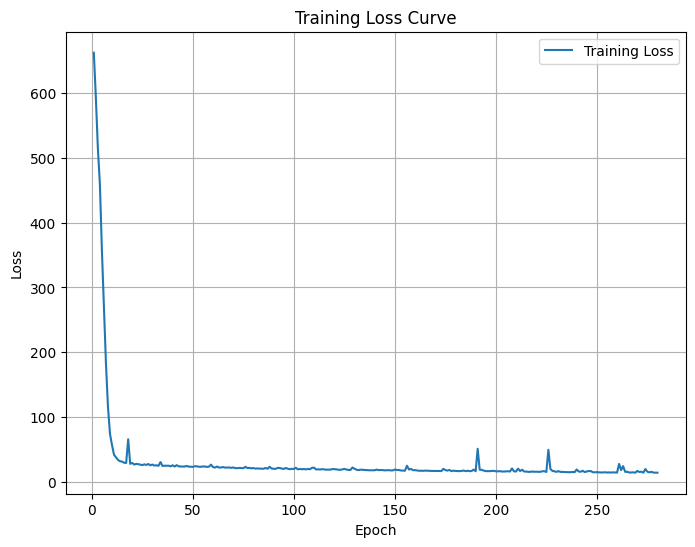

2025-04-07 17:16:06,915 - INFO - Test Loss: 17.2874


In [6]:
# 可视化训练过程
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# 加载模型
model.load_state_dict(torch.load('boston_model.pth'))    

# 10.在测试集上评估模型
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    logging.info(f'Test Loss: {test_loss.item():.4f}')